In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Query ERA5-Land data from Copernicus

[ERA5-Land](https://www.ecmwf.int/en/era5-land) is a global reanalysis dataset providing a consistent view of the evolution of land variables over several decades at an enhanced resolution compared to ERA5. The dataset has a resolution of 0.1 by 0.1 degrees and is available from the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/#!/home) as either [hourly](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview) data or aggregated using [monthly](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview) averages.

Data from the CDS can be accessed via Python using the `cdsapi` package, which is already installed on the JupyterHub. To get started, **you must first create a user account and setup your API key** as described in Section 1 [here](https://cds.climate.copernicus.eu/api-how-to#install-the-cds-api-key) (under the heading `Install the CDS API key`). You need to create a "hidden" text file in your `HOME` directory containing your `cdsapi` credentials. **It is easiest to do this using VSCode**, as "hidden" files are displayed in the VSCode file browser, unlike in JupyterLab. 

**Note:** You *do not* need to follow any of the other steps in the link above. Everything else is already installed.

This notebook illustrates the following workflows:

 1. Downloading, merging and resampling raw ERA5-Land data from Copernicus

 2. Extracting time series from the merged dataset for points (i.e. specific grid cells)
 
 3. Extracting time series from the merged dataset for polygons (i.e. aggregated over multiple grid cells)

## 1. Download, merge and resample gridded data (netCDFs)

### 1.1. A note on performance

Getting data from Copernicus can be slow - **expect downloads to take anything from hours to days**. The functions in NivaPy follow [recommended practices](https://confluence.ecmwf.int/display/CKB/Climate+Data+Store+%28CDS%29+documentation#ClimateDataStore(CDS)documentation-Efficiencytips) for querying CDS data efficiently, but it's still a slow process.

Performance depends to some extent on how many other users are downloading data at the same time. The CDS is used globally, so finding quiet times can be difficult, but it is predominantly a European service, so you might experience better performance if you run your queries at night or during the weekend. The CDS also assigns a [priority score](https://cds.climate.copernicus.eu/live/priorities) to determine when requests get processed. Users making lots of requests may be penalised, so it's a good idea to tidy up your requests by logging in to the CDS [MyRequests page](https://cds.climate.copernicus.eu/cdsapp#!/yourrequests) and deleting any failed or unnecessary requests (e.g. those submitted while developing or testing new code).

**Tip:** The CDS has a webpage [here](https://cds.climate.copernicus.eu/live/queue) showing how many requests are currently being processed and how they are queued. If you're logged in to the CDS, you can see your pending requests listed at the top of the page. Alternatively, all requests are labelled by user ID, which is part of your `cdsapi` key. You can find this in the `.cdsapirc` file you created in your `HOME` directory when you registered to use the CDS API (see above). Your API key will look something like this:

    12345:xxxxxxxx-xxxx-xxxx-1234-xxxxxxxxxxxx
    
The `12345` part before the first colon is your user ID. To see how your queries are progressing, either login or try searching the [queue summary web page](https://cds.climate.copernicus.eu/live/queue) for your user ID.

### 1.2. Available parameters

The parameters available in ERA5-Land as described [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview) (parameters are the same for the monthly and hourly datasets). Parameters are divided into two types: **instantaneous** and **accumulated**, which are represented differently in the netCDF files. It's important to understand these differences to be able to use the output correctly - **please read the documentation [here](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-Temporalfrequency)**.

The sections below show the full list of valid parameter names that can be passed to `nivapy.da.get_era5land_cds_api_gridded()`. Note that compared to the CDS website, `cdsapi` uses lowercase parameter names with spaces replaced by underscores. Furthermore, in the netCDF files themselves, shortened names are used - see the tables [here](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-Temporalfrequency) for details.

#### Instantaneous

    lake_mix_layer_temperature (lmlt)
    lake_mix_layer_depth (lmld)
    lake_bottom_temperature (lblt)
    lake_total_layer_temperature (ltlt)
    lake_shape_factor (lshf)
    lake_ice_temperature (lict)
    lake_ice_depth (licd)
    snow_cover (snowc)
    snow_depth (sde)
    snow_albedo (asn)
    snow_density (rsn)
    volumetric_soil_water_layer_1 (swvl1)
    volumetric_soil_water_layer_2 (swvl2)
    volumetric_soil_water_layer_3 (swvl3)
    volumetric_soil_water_layer_4 (swvl4)
    leaf_area_index_low_vegetation (lai_lv)
    leaf_area_index_high_vegetation (lai_hv)
    surface_pressure (sp)
    soil_temperature_level_1 (stl1)
    snow_depth_water_equivalent (sd)
    10m_u_component_of_wind (u10)
    10m_v_component_of_wind (v10)
    2m_temperature (2t)
    2m_dewpoint_temperature (2d)
    soil_temperature_level_2 (stl2)
    soil_temperature_level_3 (stl3)
    skin_reservoir_content (src)
    skin_temperature (skt)
    soil_temperature_level_4 (stl4)
    temperature_of_snow_layer (tsn)
    forecast_albedo (fal)

#### Accumulated

    surface_runoff (sro)
    sub_surface_runoff (ssro)
    snowmelt (smlt)
    snowfall (sf)
    surface_sensible_heat_flux (sshf)
    surface_latent_heat_flux (slhf)
    surface_solar_radiation_downwards (ssrd)
    surface_thermal_radiation_downwards (strd)
    surface_net_solar_radiation (ssr)
    surface_net_thermal_radiation (str)
    total_evaporation (e)
    runoff (ro)
    total_precipitation (tp)
    evaporation_from_the_top_of_canopy (evatc)
    evaporation_from_bare_soil (evabs)
    evaporation_from_open_water_surfaces_excluding_oceans (evaow)
    evaporation_from_vegetation_transpiration (evavt)
    potential_evaporation (pev)
    
When working with these datasets, keep in mind the following:

 * In the **hourly** dataset, the "accumulated" parameters **accumulate within each day**. For example, for `total precipitation`, the value in the raw netCDF for 09:00 represents the total accumulated precipitation over the 9 hour period from 00:00 to 09:00. This means the value for the last hour of each day is actually the total *daily* precipitation. **If you really want hourly, you need to calculate differences between the time steps within each day** (but only for the "accumulated" parameters, not the "instantaneous" ones!). To make things even more confusing, the value in the raw netCDF for e.g. 01.01.2020 at 00:00 is actually the total accumulated daily precipitation for 31.12.2019
 
 * In the **hourly** dataset, "instantanous" parameters behave more like you probably expect: the value for the given hour represents the model's prediction for that instant
 
 * In the **monthly** dataset things are a bit more straightforward, except that values for the "accumulated" parameters are presented as **means *per day* for the given month (*not* monthly totals)**. In other words, in the raw monthly dataset, you need to multiply values for total precipitation by the number of days in each month to get monthly totals
 
The functions in NivaPy try to behave sensibly, but it's still confusing. See the notebook [here](https://nbviewer.org/github/NIVANorge/catchment_processing_workflows/blob/main/notebooks/era5land_instant_vs_accum.ipynb) as a sense check.

In summary:

 * If you choose to download **hourly** data and do not resample (i.e. `raw_freq='H'` and `out_freq='H'`), NivaPy will download the raw hourly data and do nothing else. In this case, be aware that, **for "accumulated" parameters only**, the hourly values within each day are **cumulative**
 
 * If you choose to download **hourly** data and resample (i.e. `raw_freq='H'` and `out_freq` is `D`, `M` or `A`), NivaPy will: (i) calculate the mean for instantaneous parameters, and (ii) for accumulated parameters, first get only the values for midnight on each day (`hour == 00:00`), which represent the accumulated daily totals. Values are then "lagged" by `-1` hour (so that e.g. `01-01-2020 00:00` is associated with `31-12-2019`) and *then* means are calculated. The output for instantaneous parameters is therefore the mean over the total period specified by `out_freq`; the output for accumulated parameters is the mean **daily** rate over the whole period i.e. multiply by the number of days in the month for monthly totals, or the number of days in the year for annual totals etc.
 
If you think this all sounds unnecessarily complicated and painful, I can assure you that I suffered more writing the code! Fortunately, for the (probably) most common use case where `raw_freq='H'` and `out_freq='D'`, everything should work as expected: values for instantaneous parameters are the means over the day, and values for accumulated parameters are the accumulated daily totals.

### 1.3. Downloading data

Use `nivapy.da.get_era5land_cds_api_gridded()` to download netCDF files from the CDS and merge them into a single dataset. Before using the function, it's worth reading the `docstring` to understand the various options for subsetting and resampling.

In [2]:
nivapy.da.get_era5land_cds_api_gridded?

Signature:
nivapy.da.get_era5land_cds_api_gridded(
    pars,
    st_dt,
    end_dt,
    out_nc_path,
    raw_freq='M',
    out_freq='M',
    xmin=-180,
    ymin=-90,
    xmax=180,
    ymax=90,
)
Docstring:
Download, merge and (optionally) resample ERA5-Land data from Copernicus. Note that
getting data from Copernicus can be slow, so expect to wait hours or even days for this
function to complete!

ERA5-Land is a global reanalysis dataset with a spatial resolution of 0.1 x 0.1 degrees.
The raw data has an hourly temporal resolution, but it's also available aggregated to
monthly means.

This function allows you to specify your parameters, time period and region of interest,
and then download data from either the raw (hourly) or aggregated (monthly) dataset.

The function first downloads one netCDF file per month for the specified period, then
merges all the files into a single netCDF and saves it to disk. The separate monthly
files are then deleted. Optionally, you can choose to up- or d

In [3]:
pars = ["2m_temperature", "total_precipitation"]
st_dt = "2020-01-01"
end_dt = "2021-12-31"
out_nc_path = r"/home/jovyan/shared/JES/era5land_test/era5land_finnmark.nc"
raw_freq = "H"
out_freq = "D"

# Bounding box for Finnmark
xmin = 20.4
ymin = 68.5
xmax = 31.8
ymax = 71.4

In [4]:
%%time

ds = nivapy.da.get_era5land_cds_api_gridded(
    pars,
    st_dt,
    end_dt,
    out_nc_path,
    raw_freq=raw_freq,
    out_freq=out_freq,
    xmin=xmin,
    ymin=ymin,
    xmax=xmax,
    ymax=ymax,
)
ds

Getting data from Copernicus. This may take a while...


2022-02-24 22:17:58,205 INFO Welcome to the CDS
2022-02-24 22:17:58,206 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2022-02-24 22:17:58,261 INFO Request is completed
2022-02-24 22:17:58,262 INFO Downloading https://download-0003.copernicus-climate.eu/cache-compute-0003/cache/data3/adaptor.mars.internal-1645641308.9644263-23743-10-1601e433-f78d-4cdf-89ea-b13b152e7ed5.nc to /home/jovyan/shared/JES/era5land_test/era5land_temp/era5land_raw_hourly_2020-01.nc (9.8M)
2022-02-24 22:17:58,718 INFO Download rate 21.5M/s  
2022-02-24 22:17:58,754 INFO Welcome to the CDS
2022-02-24 22:17:58,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2022-02-24 22:17:58,835 INFO Downloading https://download-0015.copernicus-climate.eu/cache-compute-0015/cache/data6/adaptor.mars.internal-1645644046.605841-15829-19-5ea90224-f690-46a3-9bf5-abf7331aa3df.nc to /home/jovyan/shared/JES/era5land_test/era5land_temp/er

Processing downloaded datasets...
CPU times: user 11.2 s, sys: 1.87 s, total: 13.1 s
Wall time: 23.1 s


<xarray.Dataset>
Dimensions:    (time: 731, longitude: 115, latitude: 30)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2021-12-31
  * longitude  (longitude) float32 20.4 20.5 20.6 20.7 ... 31.5 31.6 31.7 31.8
  * latitude   (latitude) float32 71.4 71.3 71.2 71.1 ... 68.8 68.7 68.6 68.5
Data variables:
    t2m        (time, latitude, longitude) float32 nan nan nan ... 264.9 264.9
    tp         (time, latitude, longitude) float32 nan nan nan ... nan nan nan

## 2. Get time series for points (i.e. specific grid cells)

### 2.1. Example data

As a starting point, the user must supply a dataframe listing the locations of interest. The dataframe must include columns for the x and y co-ordinates, plus a column with a unique identifier for each location (in other words, each row of the dataframe should have a unique identifier).

Data can be provided in any co-ordinate system you wish, but if the co-ordinates are not WGS84-based lat/lon (the default), you **must remember to explicitly specify the CRS**. The ERA5-Land data uses EPSG 4326, so whatever data you provide will first be reprojected to this CRS before extracting the points. This is handled automatically, *as long as you specify the original CRS correctly* (see below).

In [5]:
# Read example data from Finnmark
csv_path = "../example_data/quantom_catchment_outlets.csv"
df = pd.read_csv(csv_path, sep=";")

df.head()

,site_id,site_name,outlet_lat,outlet_lon,outlet_elev_m
0,1,Njahkajavri,68.879606,23.761291,480
1,2,Vuomajeaggi,69.016558,24.142340,365
2,3,Juovvajohka,69.091233,24.473330,311
3,4,Caskin-jeaggi / Caskinjohka,68.926158,25.597493,211
4,6,Fáhttevárleakšá,69.594406,25.012381,350


### 2.2. Get time series

In [6]:
st_dt = "2020-01-01"
end_dt = "2021-12-31"
nc_path = r"/home/jovyan/shared/JES/era5land_test/era5land_finnmark.nc"

In [7]:
res_df = nivapy.da.get_era5land_cds_api_time_series(
    df,
    nc_path,
    st_dt,
    end_dt,
    id_col="site_id",
    xcol="outlet_lon",
    ycol="outlet_lat",
    crs="epsg:4326",
)
res_df.head()

,datetime,site_id,longitude,latitude,t2m,tp
0,2020-01-01,1,23.799999,68.900002,262.275238,0.004906
1,2020-01-01,2,24.100000,69.000000,262.654572,0.004807
2,2020-01-01,3,24.500000,69.099998,261.944489,0.005193
3,2020-01-01,4,25.600000,68.900002,262.944458,0.004133
4,2020-01-01,6,25.000000,69.599998,261.014832,0.004505


In [8]:
# K to C
res_df["t2m"] = res_df["t2m"] - 273.15

# m to mm
res_df["tp"] = 1000 * res_df["tp"]

# Convert to long format
res_df = res_df.melt(
    id_vars=["datetime", "site_id", "longitude", "latitude"], var_name="par"
)

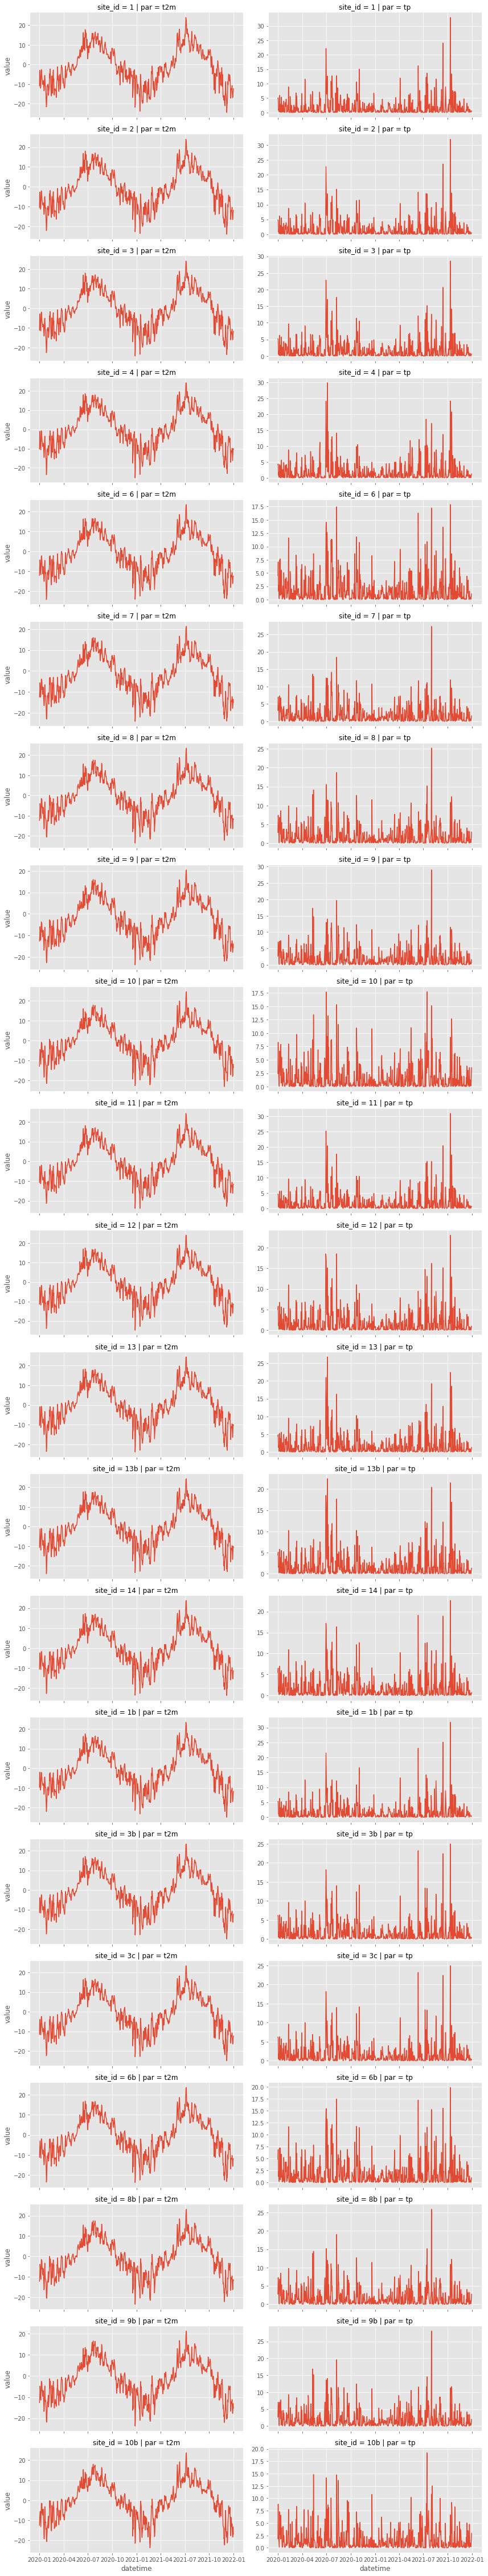

In [9]:
# Plot
sn.relplot(
    data=res_df,
    x="datetime",
    y="value",
    col="par",
    row="site_id",
    kind="line",
    height=3,
    aspect=2,
    facet_kws={"sharey": False, "sharex": True},
)

### 2.3. Compare with results from NVE's GTS API

For sites in Norway, [the GTS API](https://nbviewer.org/github/NIVANorge/catchment_processing_workflows/blob/main/notebooks/nve_gts_api_example.ipynb) provides high resolution data that is much faster to access (although ERA5-Land offers more variables).

In [10]:
gts_pars = ["tm", "rr"]

gts_df = nivapy.da.get_nve_gts_api_time_series(
    df,
    gts_pars,
    st_dt,
    end_dt,
    id_col="site_id",
    xcol="outlet_lon",
    ycol="outlet_lat",
    crs="epsg:4326",
)
gts_df.head()

Looping over parameters:   0%|          | 0/2 [00:00<?, ?it/s]

Looping over grid cells:   0%|          | 0/21 [00:00<?, ?it/s]

Looping over grid cells:   0%|          | 0/21 [00:00<?, ?it/s]

,site_id,x_utm_33n,y_utm_33n,altitude_m,par,full_name,unit,time_resolution,datetime,value
0,1,851298,7666054,492,tm,Døgntemperatur v2.0,Celcius,1440,2020-01-01 06:00:00,-12.65
1,1,851298,7666054,492,tm,Døgntemperatur v2.0,Celcius,1440,2020-01-02 06:00:00,-9.55
2,1,851298,7666054,492,tm,Døgntemperatur v2.0,Celcius,1440,2020-01-03 06:00:00,-0.15
3,1,851298,7666054,492,tm,Døgntemperatur v2.0,Celcius,1440,2020-01-04 06:00:00,-8.05
4,1,851298,7666054,492,tm,Døgntemperatur v2.0,Celcius,1440,2020-01-05 06:00:00,-11.05


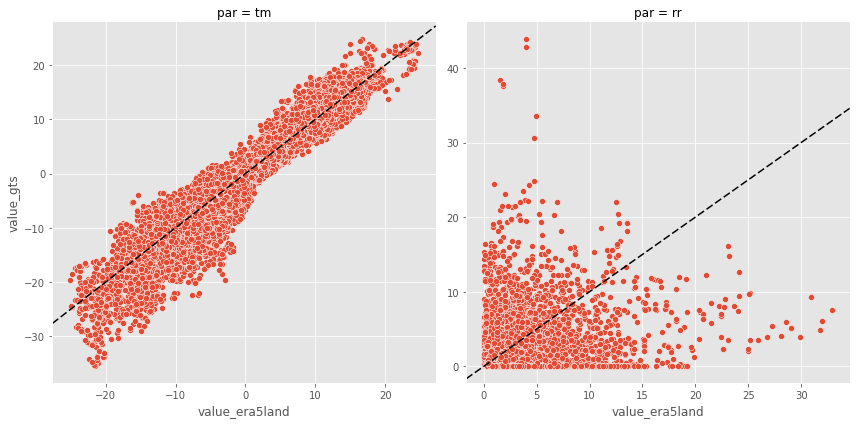

In [11]:
# Rename ERA5 pars to match GTS
res_df["par"].replace({"t2m": "tm", "tp": "rr"}, inplace=True)

# Remove time component from GTS datetimes
gts_df["datetime"] = pd.to_datetime(gts_df["datetime"].dt.date)

comp_df = pd.merge(
    res_df,
    gts_df,
    on=["datetime", "site_id", "par"],
    how="inner",
    suffixes=["_era5land", "_gts"],
)

g = sn.relplot(
    data=comp_df,
    x="value_era5land",
    y="value_gts",
    col="par",
    height=6,
    facet_kws={"sharey": False, "sharex": False},
)
for ax in g.axes_dict.values():
    ax.axline(xy1=(0, 0), slope=1, color="k", dashes=(5, 2))

Dotted lines on the plots above show the 1:1 line, not the "best fit" line.

Based on this, ERA5-Land seems to provide reasonable estimates of temperature, but predictions for rainfall are poor. 

Note that the "rainfall" variables used here are not exactly comparable: ERA5-Land offers "total precipitation" (and then snow separately), whereas GTS offers "Døgnnedbør" and snow separately. The plot compares ERA5 "total precipitation" with GTS "Døgnnedbør". Subtracting the snow component from ERA5-Land or combining the two components from GTS would make the comparison fairer, but looking at the scatterplot I don't think it would solve the problem. 

## 3. Get time series for polygons (i.e. aggregate multiple grid cells)

### 3.1. Example data

The user must supply a geodataframe containing the polygons of interest. This could be read e.g. from a shapefile or from GeoJSON. Each row of the dataframe should represent one area of interest (use a [spatial dissolve](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) operation first if necessary) and there must be a column containing a unique identifier for each polygon.

The example here uses a geodataframe containing catchment boundaries for 21 small catchments in Finnmark.

In [12]:
# Example catchments in Finnmark
shp_path = r"../example_data/catchment_boundaries_2021.shp"
gdf = gpd.read_file(shp_path)
gdf.head()

,vassdragNr,areal_km2,site_name,site_id,geometry
0,234.GEB,9.40,Njahkajavri,1,"POLYGON ((850817.528 7669267.751, 851025.000 7..."
1,234.J3A0,84.26,Caskin-jeaggi / Caskinjohka,4,"POLYGON ((914016.660 7689380.680, 914222.460 7..."
2,234.GDAZ,41.24,Juovvajohka,3,"POLYGON ((870050.000 7694700.000, 870081.269 7..."
3,234.F3BZ,27.38,Gurrojohka,9,"POLYGON ((919269.498 7802100.122, 919364.457 7..."
4,234.GEA0,24.86,Vuomajeaggi,2,"POLYGON ((864315.450 7683072.205, 864387.977 7..."


### 2.2. Get aggregated time series

**Be sure that the CRS of the geodataframe is set correctly before querying the ERA5 netCDF**.

For each polygon-timestamp combination, and for each variable in the netCDF files, the function returns the minimum, median, maximum, mean, standard deviation and count of grid cell values within the polygon. Note in particular that `value_count` is the number of 0.1 degree by 0.1 degree cell centres located within each polygon. **Remember that the area of pixels in decimal degrees varies with latitude**, so use these pixel counts with caution. In particular, unlike for the GTS API or NGCD, the `count` column gives an approximate measure of the size of each polygon in *squared decimal degrees*, which is **not** very meaningful. Be sure to reproject to a suitable CRS for further analysis.

In [13]:
%%time

res_df = nivapy.da.get_era5land_cds_api_aggregated_time_series(
    gdf,
    nc_path,
    st_dt,
    end_dt,
    id_col="site_id",
)
res_df.head()

CPU times: user 4.3 s, sys: 2.74 s, total: 7.04 s
Wall time: 7.07 s


/opt/conda/lib/python3.9/site-packages/nivapy3-0.1-py3.9.egg/nivapy3/da.py:2688: UserWarning: The following catchments do not contain any grid cell centres:
['1', '13', '13b', '1b', '3', '3b', '3c', '6', '8', '8b', '9b']
Summary statistics for these catchments have not been calculated. This is a known limitation that will be fixed soon.


,site_id,par,datetime,value_min,value_median,value_max,value_mean,value_std,value_count
,,,,,,,,,
0,10,t2m,2020-01-01,260.624054,260.624054,260.624054,260.624054,0.0,2.0
1,10,t2m,2020-01-02,263.964386,263.964386,263.964386,263.964386,0.0,2.0
2,10,t2m,2020-01-03,268.285400,268.285400,268.285400,268.285400,0.0,2.0
3,10,t2m,2020-01-04,267.765167,267.765167,267.765167,267.765167,0.0,2.0
4,10,t2m,2020-01-05,264.611603,264.611603,264.611603,264.611603,0.0,2.0


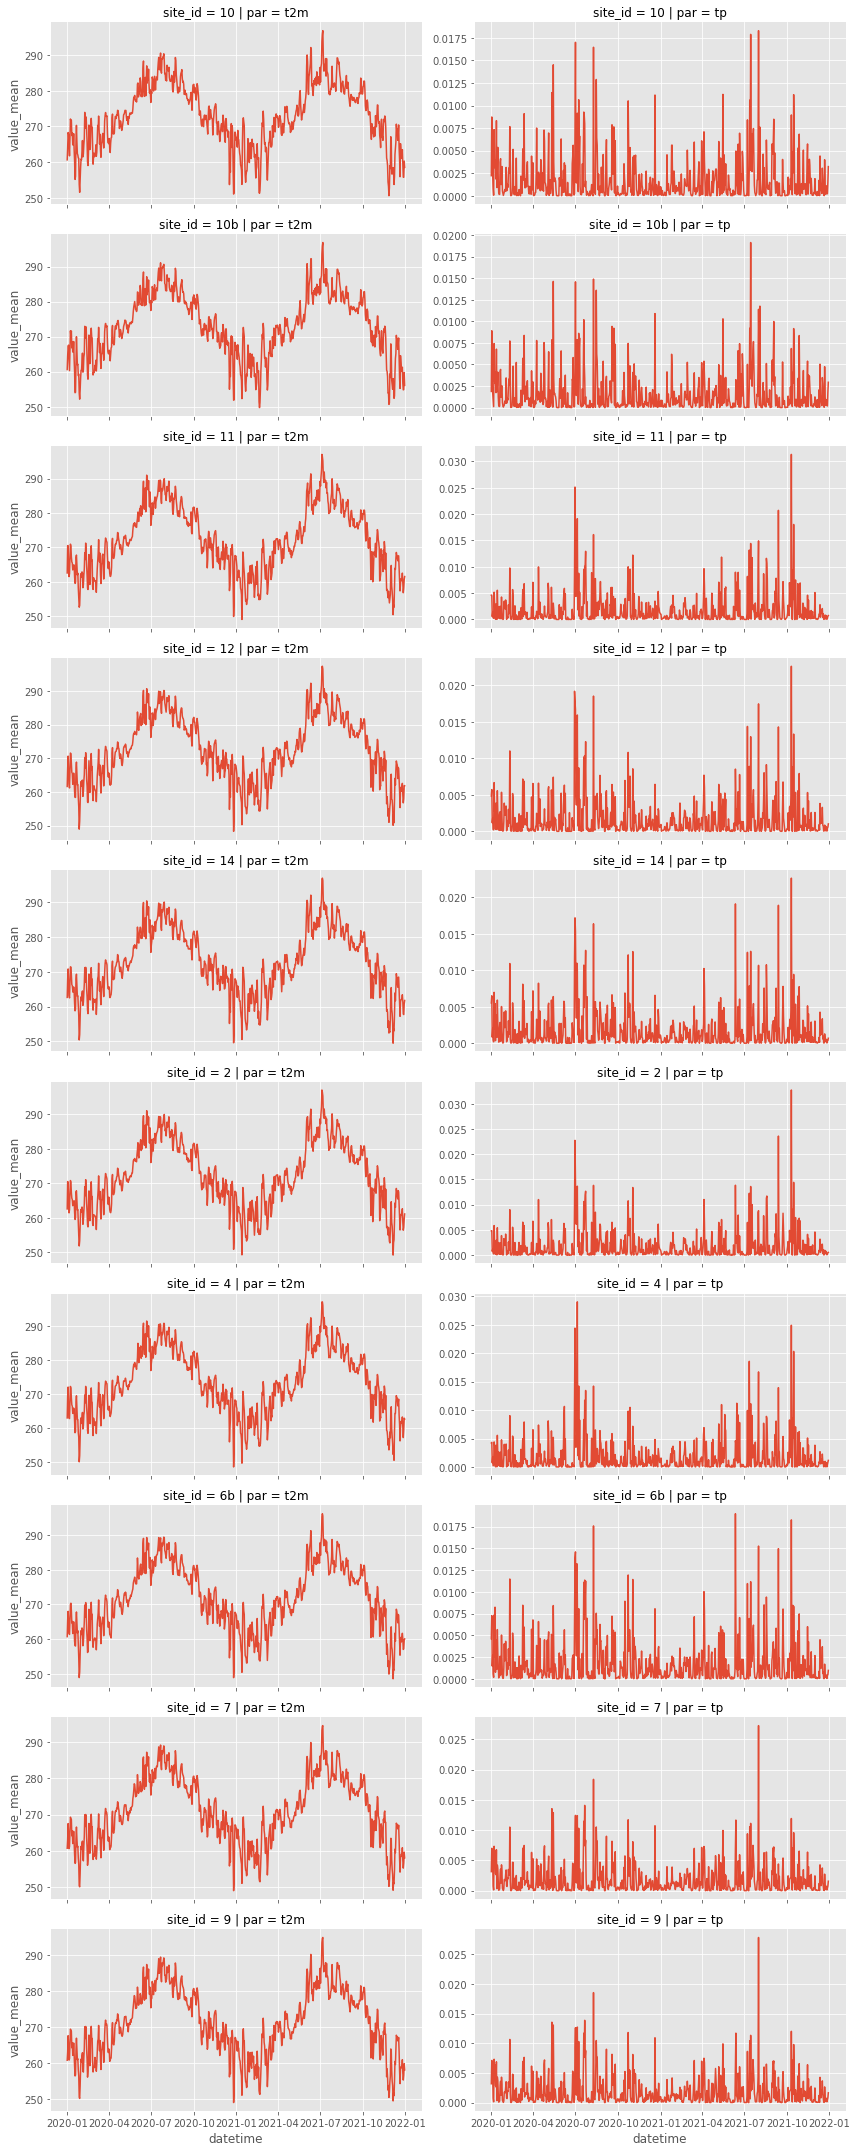

In [14]:
# Plot
sn.relplot(
    data=res_df,
    x="datetime",
    y="value_mean",
    col="par",
    row="site_id",
    kind="line",
    height=3,
    aspect=2,
    facet_kws={"sharey": False, "sharex": True},
)